# Processamento da descrição do serviço de nota fiscal para predição da atividade econômica

In [1]:
## for data
import numpy as np
import pandas as pd
import pickle
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
from nltk.corpus import stopwords
from nltk import bigrams
import re
import string
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline
## for bag-of-words
from wordcloud import WordCloud
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
## for ML
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, hamming_loss, confusion_matrix, classification_report, roc_curve, auc
from joblib import dump, load

In [2]:
d_configuracao = {'display.max_columns': 30,
                  'display.expand_frame_repr': True,
                  'display.max_rows': 120,
                  'display.precision': 2,
                  'display.show_dimensions': True,
                 'display.float_format': '{:,.4f}'.format}

for op, value in d_configuracao.items():
    pd.set_option(op, value)
    print(op, value)

display.max_columns 30
display.expand_frame_repr True
display.max_rows 120
display.precision 2
display.show_dimensions True
display.float_format <built-in method format of str object at 0x7f48ddd5f730>


In [3]:
def add2vocab(doc, vocab):
    tokens = clean_doc(doc, False)
    vocab.update(tokens)

def lc2vocab(doc, vocab):
    l_lc = []
    if doc is not None: 
        doc = re.sub(r'[^\w\s]', '', str(doc))
        l_lc.append(doc)
        vocab.update(l_lc)
        
def add2vocab2(bigramas, vocab2):
    tokens = bigramas.split(',')
    vocab2.update(tokens)        

def clean_doc(doc=None, string_=True):
    ''' # turn a doc into clean tokens '''
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens if not word.isdigit()]
    # filter out stop words
    stop_words = set(stopwords.words('portuguese'))
    stop_words.update(['<br />'])
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    if string_: return " ".join(tokens)
    else: return tokens
    
def save_list(lines, filename):
    ''' convert lines to a single blob of text '''
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()    
    
def doc_to_line(cols):   
    ''' limpa e filtra vocab '''
    lc = cols[0]
    text = cols[1]
    l_text_clean = clean_doc(text, False)
    l_text_clean = [w for w in l_text_clean if w in l_vocab]
    l_lc = list()
    lc_clean = re.sub(r'[^\w\s]', '', str(lc))
    if lc_clean in l_vocab:
        l_lc.append(lc_clean)  
        l_lc.extend(l_text_clean)
        return " ".join(l_lc)
    else: return " ".join(l_text_clean)
    
def doc_to_list(lc, text):   
    ''' limpa e filtra vocab '''
    l_text_clean = clean_doc(text, False)
    l_text_clean = [w for w in l_text_clean if w in l_vocab]
    l_lc = list()
    lc_clean = re.sub(r'[^\w\s]', '', str(lc))
    if lc_clean in l_vocab:
        l_lc.append(lc_clean)  
        l_lc.extend(l_text_clean)
        return l_lc
    else: return l_text_clean    

def bigram_deep(text_clean):
    l_text = text_clean.split()
    l_bi = list(bigrams(l_text))
    l_bi2 = []
    for tup in l_bi:
        l_bi2.append(tup[0] + ' ' + tup[1])
    l_text.extend(l_bi2)
    return ','.join(l_text)

def text2bigram(text):
    l_text = clean_doc(text, False)
    l_bi = list(bigrams(l_text))
    l_bi2 = []
    for tup in l_bi:
        l_bi2.append(tup[0] + ' ' + tup[1])
    return ','.join(l_bi2) 

def drop_dfindex(df, index):
    return df.drop(index=index)

def teste_chi2(docs=None, y=None, vectorizer=None, p_value_limit = 0.95):
        ''' chi-squared test to dermine whether a feature and target are independent - statistically relevant
            keep only features with p_value_limit = 0.95 '''
        #vectorizer = TfidfVectorizer(ngram_range=(1,2))
        #vectorizer.fit(docs)
        #X = vectorizer.transform(docs)
        X = vectorizer.fit_transform(docs)
        X_names = vectorizer.get_feature_names()
        print('tamanho_vocabulario = ', len(vectorizer.vocabulary_))
        print(X.shape)
        df_features = pd.DataFrame()
        for cat in np.unique(y):
            chi2_, p = chi2(X, y == cat)
            df_features = df_features.append(pd.DataFrame({'feature': X_names, 'score': 1-p, 'y': cat}))
        df_features = df_features.sort_values(['y', 'score'], ascending=[True, False])
        df_features = df_features[df_features['score'] > p_value_limit]
        print(df_features.sample(10))
        print('vocab_testado:', df_features.feature.nunique())
        return df_features.feature.unique().tolist()
        #return df_features
        
def load_doc(filename):
    ''' # load doc into memory '''
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text      

In [4]:
path = r'../data/dataset_ML_treino.parq'
treino = pd.read_parquet(path, engine='auto')
treino.shape

(224000, 3)

(224000, 3)


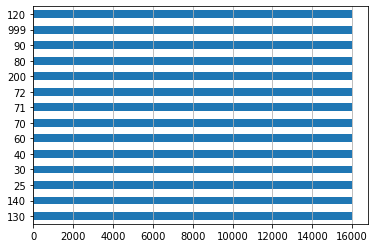

In [5]:
# atividades econômicas classificadas pelo código do bloco P100 da EFD-Contribuições (SPED)
# 999: amostras de atividades não listadas
i_classes = treino.y.nunique()
print(treino.shape)
treino.y.value_counts().sort_values().plot(kind='barh', legend=False).grid(axis='x');

In [6]:
# retirar registros do dataset de treino
#treino.loc[treino.text.str.contains('\x80')]

In [7]:
treino = drop_dfindex(treino, treino.loc[treino.text.str.contains('\x80')].index)

In [8]:
#treino.loc[treino.text.str.contains('\x87')]

In [9]:
treino = drop_dfindex(treino, treino.loc[treino.text.str.contains('\x87')].index)

In [10]:
# montagem do vocabulário unigramas
# limpeza do texto: remoção de pontuação, stopwords, caracteres isolados e números
# foi mantido o nr correspondente ao código da ativiade econômica quando informado
vocab = Counter()
_ = treino.text.apply(lambda x: add2vocab(x, vocab))
_ = treino.cd_lc.apply(lambda x: lc2vocab(x, vocab))
print(len(vocab))
print(vocab.most_common(10))

10359
[('servico', 27908), ('servicos', 25137), ('1401', 23711), ('2001', 14670), ('transporte', 12317), ('702', 10867), ('pacote', 10224), ('1601', 10023), ('901', 9743), ('manutencao', 9247)]


In [11]:
# mantém token com uma ocorrência mínima
min_occurrence = 2
l_vocab = [k for k,c in vocab.items() if c >= min_occurrence]
# salva tokens em arquivo texto
save_list(l_vocab, r'../best_models/vocab.txt')

print(len(l_vocab))

6350


In [12]:
# bigramas
treino['bigrams'] = treino['text'].apply(lambda x: text2bigram(x))

In [13]:
# montagem do vocabulário bigramas
# limpeza do texto: remoção de pontuação, stopwords, caracteres isolados e números
vocab2 = Counter()
_ = treino.bigrams.apply(lambda x: add2vocab2(x, vocab2))
del vocab2['']
print(len(vocab2))
print(vocab2.most_common(10))

21960
[('locacao vaga', 7820), ('pacote positron', 7386), ('passageiros dinheiro', 6787), ('gerenciamento residuos', 6297), ('sv portuario', 5318), ('portuario fiscal', 5318), ('servicos prestados', 5257), ('maodeobra oficina', 5217), ('codigo servico', 4144), ('servico importado', 4143)]


In [14]:
# unigramas com limpeza do texto
treino['text_clean'] = treino[['cd_lc','text']].apply(doc_to_line, axis=1)

In [15]:
# bow: bag of words
unigrams = treino.text_clean
bow = " ".join(unigrams)

In [16]:
# gerando WordCloud
wordcloud = WordCloud(background_color="black",
                      width=1600, height=800,max_words=400,min_word_length=2).generate(bow)

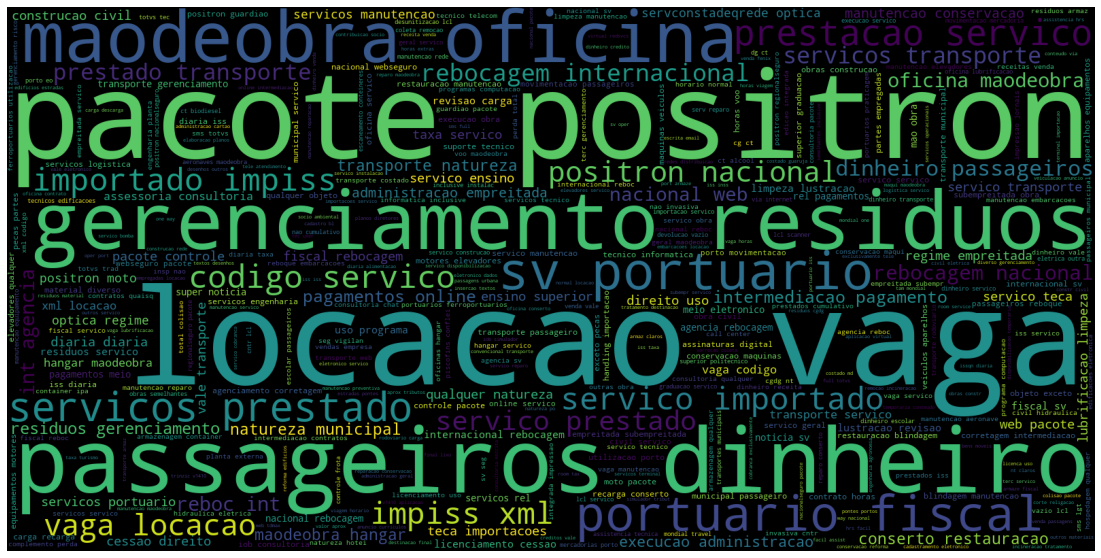

In [17]:
# plotando WordCloud
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);
wordcloud.to_file("wordcloud_desc_it.png")

[Text(0, 0.5, '')]

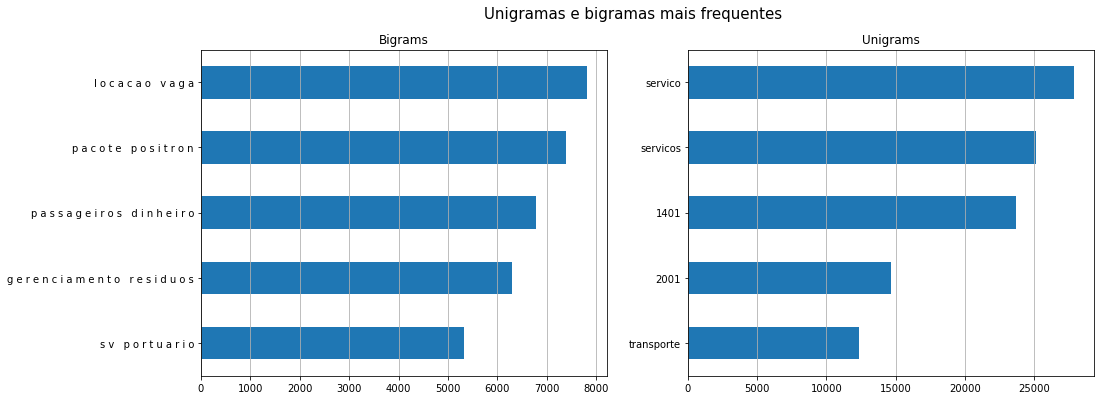

In [18]:
# unigramas e bigramas mais frequentes
top = 5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle('Unigramas e bigramas mais frequentes', fontsize=15)
## unigrams
df_uni = pd.DataFrame(vocab.most_common(), columns=['word','freq'])
df_uni.set_index('word').iloc[:top,:].sort_values(by='freq').plot(kind='barh', title='Unigrams', ax=ax[1],
                                                                 legend=False).grid(axis='x')
ax[1].set(ylabel=None)
## bigrams
df_bi = pd.DataFrame(vocab2.most_common(), columns=['word','freq'])
df_bi.word = df_bi.word.apply(lambda x: ' '.join(string for string in x))
df_bi.set_index('word').iloc[:top,:].sort_values(by='freq').plot(kind="barh", title="Bigrams", ax=ax[0], 
                                                                 legend=False).grid(axis='x')
ax[0].set(ylabel=None)

In [19]:
def plot_uni_bigramas(y, desc):
    ''' plota unigramas e bigramas de classe '''
    # vocab unigramas
    vocab_y = Counter()
    _ = treino.loc[treino.y == y].text.apply(lambda x: add2vocab(x, vocab_y))
    _ = treino.loc[treino.y == y].cd_lc.apply(lambda x: lc2vocab(x, vocab_y))  
    print('Tamanho vocabulario unigramas:',len(vocab_y))
    print('Unigramas mais comuns:',vocab_y.most_common(10))    
    # vocab bigramas
    vocab_y2 = Counter()
    _ = treino.loc[treino.y == y].bigrams.apply(lambda x: add2vocab2(x, vocab_y2))
    del vocab_y2['']
    print('Tamanho vocabulario bigramas:',len(vocab_y2))
    print('Bigramas mais comuns',vocab_y2.most_common(10))    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle('Unigramas e bigramas mais frequentes y = ' + str(y) + ' ' + desc , fontsize=15)
    ## unigrams
    df_uni = pd.DataFrame(vocab_y.most_common(), columns=['word','freq'])
    df_uni.set_index('word').iloc[:top,:].sort_values(by='freq').plot(kind='barh', title='Unigrams', ax=ax[1],
                                                                     legend=False).grid(axis='x')
    ax[1].set(ylabel=None)
    ## bigrams
    df_bi = pd.DataFrame(vocab_y2.most_common(), columns=['word','freq'])
    df_bi.word = df_bi.word.apply(lambda x: ' '.join(string for string in x))
    df_bi.set_index('word').iloc[:top,:].sort_values(by='freq').plot(kind="barh", title="Bigrams", ax=ax[0], 
                                                                     legend=False).grid(axis='x')
    ax[0].set(ylabel=None)  

Tamanho vocabulario unigramas: 2520
Unigramas mais comuns: [('107', 4228), ('105', 2957), ('uso', 2250), ('licenciamento', 2108), ('sms', 2008), ('servicos', 1944), ('103', 1747), ('cessao', 1715), ('101', 1492), ('direito', 1443)]
Tamanho vocabulario bigramas: 4440
Bigramas mais comuns [('direito uso', 1420), ('cessao direito', 1401), ('licenciamento cessao', 1189), ('uso programas', 720), ('sms lgt', 658), ('programas computacao', 651), ('servicos prestados', 634), ('uso programa', 623), ('programa computacao', 588), ('sms totvs', 531)]


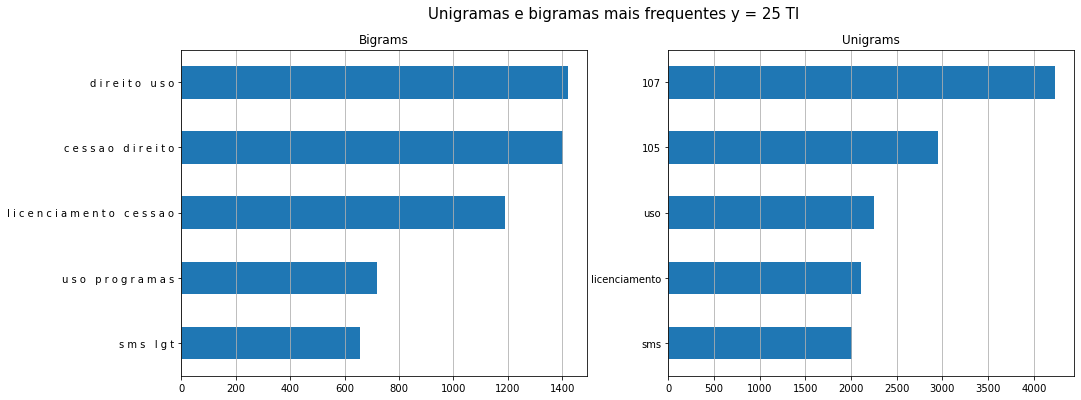

In [20]:
plot_uni_bigramas(25, 'TI')

Tamanho vocabulario unigramas: 820
Unigramas mais comuns: [('pacote', 10196), ('positron', 7536), ('nacional', 4110), ('web', 2484), ('controle', 1895), ('moto', 1456), ('1701', 1274), ('webseguro', 1097), ('guardiao', 903), ('servico', 872)]
Tamanho vocabulario bigramas: 1203
Bigramas mais comuns [('pacote positron', 7386), ('positron nacional', 3726), ('nacional web', 2457), ('pacote controle', 1872), ('positron moto', 1444), ('nacional webseguro', 1097), ('positron guardiao', 903), ('assessoria consultoria', 599), ('positron regionalseguro', 557), ('complemento perda', 526)]


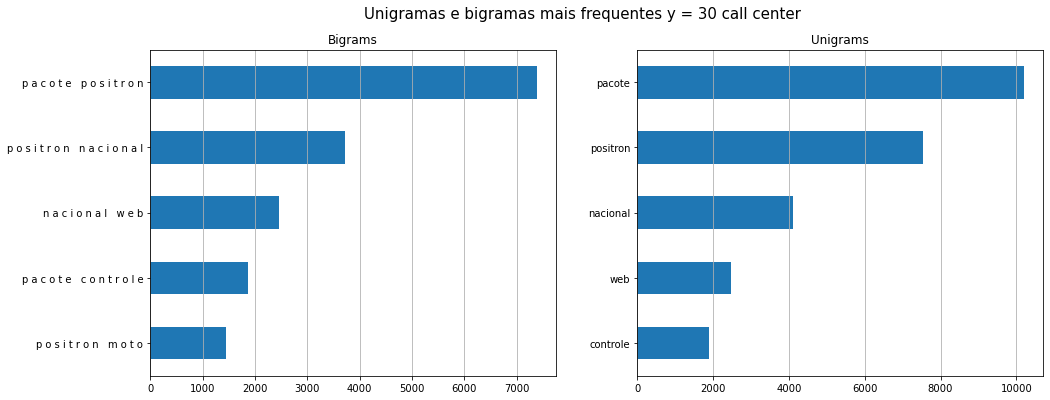

In [21]:
plot_uni_bigramas(30, 'call center')

Tamanho vocabulario unigramas: 694
Unigramas mais comuns: [('901', 9707), ('diaria', 5152), ('iss', 2489), ('servico', 2228), ('taxa', 2054), ('hospedagem', 1015), ('servicos', 719), ('diarias', 698), ('room', 653), ('turismo', 535)]
Tamanho vocabulario bigramas: 830
Bigramas mais comuns [('taxa servico', 1445), ('codigo servico', 496), ('servico importado', 496), ('importado impiss', 496), ('impiss xml', 463), ('hospedagem qualquer', 449), ('qualquer natureza', 449), ('natureza hoteis', 350), ('room tax', 277), ('contribuicao socio', 270)]


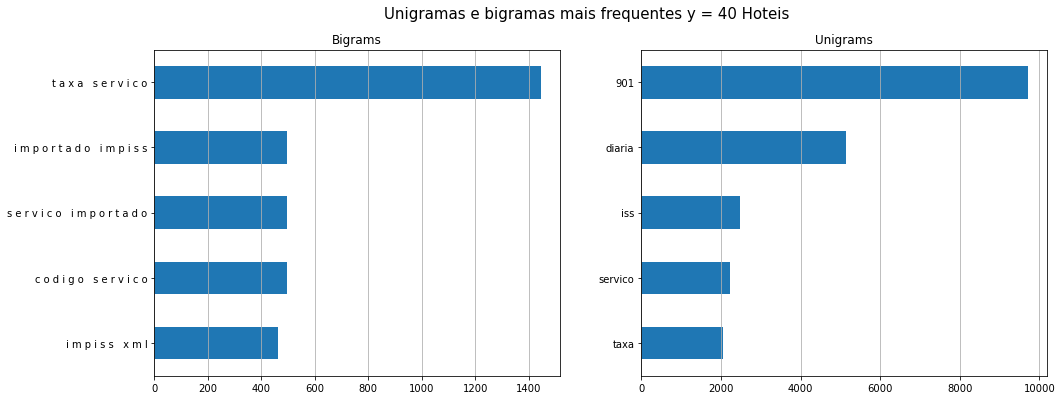

In [22]:
plot_uni_bigramas(40, 'Hoteis')

Tamanho vocabulario unigramas: 430
Unigramas mais comuns: [('passageiros', 7764), ('dinheiro', 6788), ('1601', 3817), ('transporte', 3433), ('municipal', 1829), ('vale', 1826), ('escolar', 1075), ('servicos', 902), ('venda', 875), ('web', 668)]
Tamanho vocabulario bigramas: 616
Bigramas mais comuns [('passageiros dinheiro', 6787), ('vale transporte', 1522), ('transporte web', 639), ('transporte passageiros', 586), ('servicos transporte', 549), ('passageiros municipal', 455), ('transporte municipal', 451), ('receitas vendas', 449), ('vendas empresa', 440), ('natureza municipal', 409)]


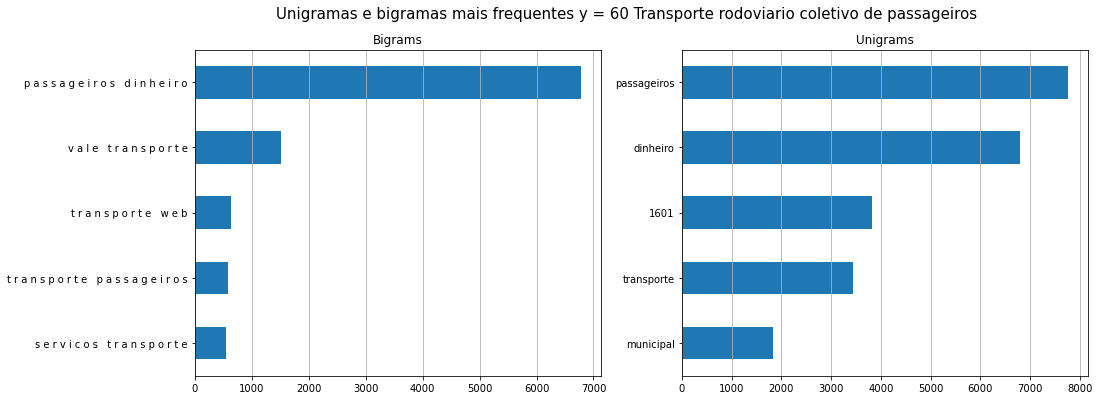

In [23]:
plot_uni_bigramas(60, 'Transporte rodoviario coletivo de passageiros')

Tamanho vocabulario unigramas: 607
Unigramas mais comuns: [('residuos', 6260), ('gerenciamento', 6252), ('709', 4814), ('servico', 3391), ('transporte', 3347), ('1601', 3252), ('prestado', 2940), ('armaz', 1243), ('claros', 1231), ('terc', 1171)]
Tamanho vocabulario bigramas: 970
Bigramas mais comuns [('gerenciamento residuos', 6240), ('servico prestado', 2940), ('prestado transporte', 2940), ('material diverso', 885), ('cgdg nt', 507), ('cg ct', 454), ('ct alcool', 453), ('ct biodiesel', 388), ('dg ct', 366), ('natureza municipal', 314)]


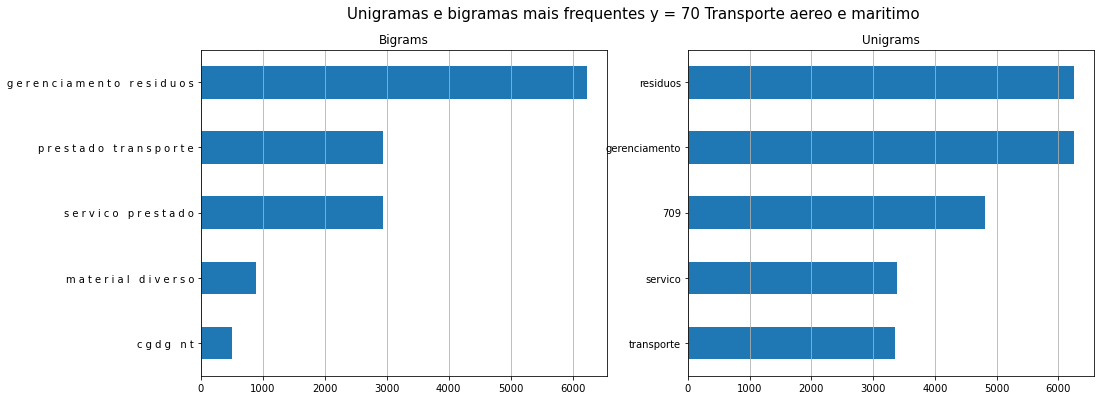

In [24]:
plot_uni_bigramas(70, 'Transporte aereo e maritimo')

Tamanho vocabulario unigramas: 266
Unigramas mais comuns: [('maodeobra', 8075), ('1401', 7606), ('oficina', 5217), ('hangar', 2838), ('manutencao', 2670), ('servico', 1934), ('conserto', 1669), ('restauracao', 1488), ('reparo', 1463), ('servicos', 1444)]
Tamanho vocabulario bigramas: 332
Bigramas mais comuns [('maodeobra oficina', 5217), ('maodeobra hangar', 2193), ('conserto restauracao', 1485), ('manutencao conservacao', 1125), ('servico geral', 1060), ('lubrificacao limpeza', 1039), ('contrato horas', 971), ('horas voo', 971), ('restauracao manutencao', 917), ('lustracao revisao', 659)]


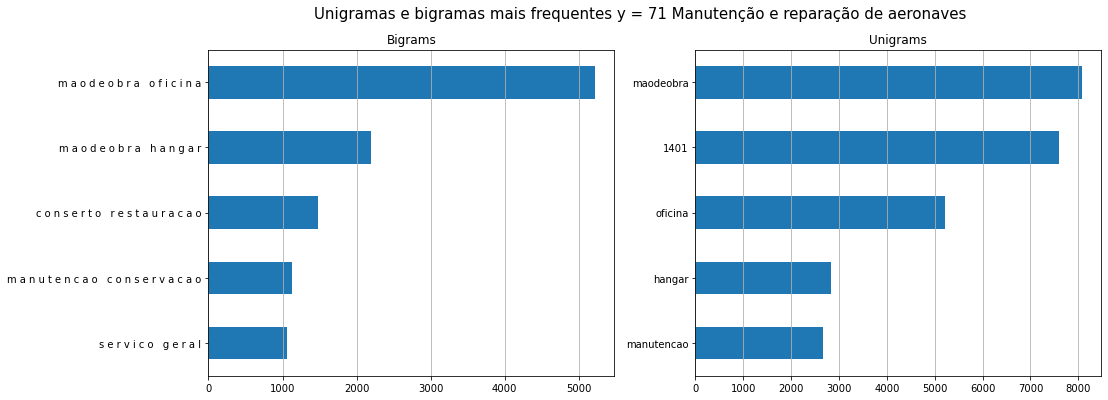

In [25]:
plot_uni_bigramas(71, 'Manutenção e reparação de aeronaves')

Tamanho vocabulario unigramas: 433
Unigramas mais comuns: [('rebocagem', 6368), ('2001', 4862), ('portuario', 4369), ('fiscal', 4093), ('sv', 4037), ('internacional', 3520), ('nacional', 2860), ('agencia', 2721), ('reboc', 2696), ('int', 2695)]
Tamanho vocabulario bigramas: 491
Bigramas mais comuns [('sv portuario', 4036), ('portuario fiscal', 4036), ('rebocagem internacional', 3520), ('rebocagem nacional', 2837), ('reboc int', 2695), ('int agencia', 2695), ('servicos portuarios', 677), ('utilizacao porto', 579), ('portuarios ferroportuarios', 576), ('ferroportuarios utilizacao', 576)]


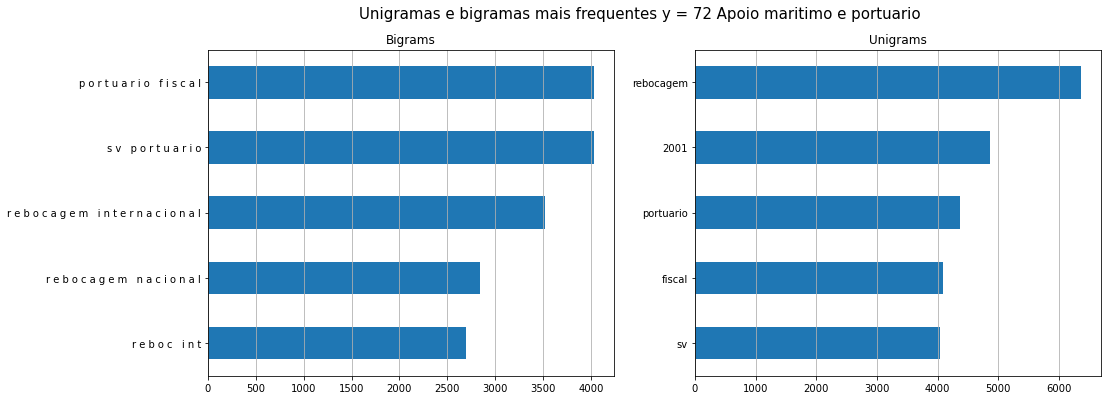

In [26]:
plot_uni_bigramas(72, 'Apoio maritimo e portuario')

Tamanho vocabulario unigramas: 386
Unigramas mais comuns: [('1401', 13459), ('locacao', 7824), ('vaga', 7820), ('servico', 3014), ('importado', 2878), ('impiss', 2878), ('codigo', 2875), ('xml', 2864), ('manutencao', 1856), ('equipamentos', 981)]
Tamanho vocabulario bigramas: 451
Bigramas mais comuns [('locacao vaga', 7820), ('importado impiss', 2878), ('codigo servico', 2875), ('servico importado', 2875), ('impiss xml', 2864), ('horario normal', 672), ('manutencao embarcacoes', 609), ('lubrificacao limpeza', 599), ('limpeza lustracao', 599), ('lustracao revisao', 599)]


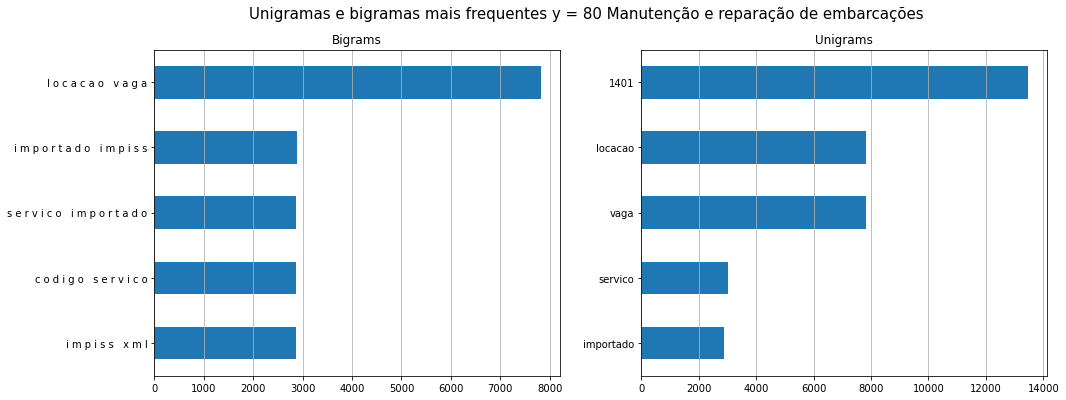

In [27]:
plot_uni_bigramas(80, 'Manutenção e reparação de embarcações')

Tamanho vocabulario unigramas: 2611
Unigramas mais comuns: [('servicos', 4442), ('702', 4153), ('servico', 3072), ('manutencao', 2328), ('execucao', 2038), ('construcao', 1864), ('civil', 1836), ('empreitada', 1681), ('prestados', 1594), ('obras', 1526)]
Tamanho vocabulario bigramas: 4605
Bigramas mais comuns [('servicos prestados', 1558), ('construcao civil', 1218), ('execucao administracao', 878), ('administracao empreitada', 821), ('servico manutencao', 815), ('prestacao servicos', 759), ('manutencao elevadores', 695), ('mao obra', 690), ('empreitada subempreitada', 606), ('regime empreitada', 591)]


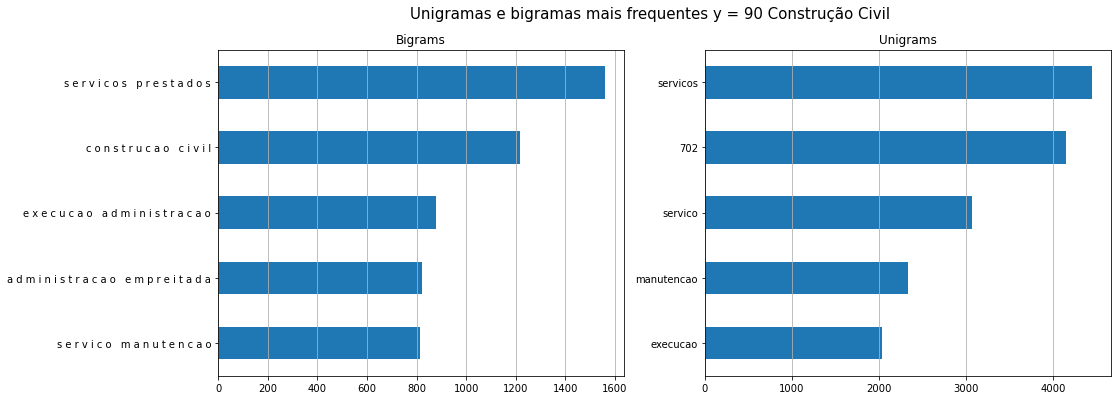

In [28]:
plot_uni_bigramas(90, 'Construção Civil')

Tamanho vocabulario unigramas: 1760
Unigramas mais comuns: [('702', 6635), ('servicos', 3872), ('servico', 3305), ('empreitada', 2490), ('execucao', 1903), ('prestados', 1553), ('civil', 1342), ('3101', 1243), ('administracao', 1219), ('obra', 1166)]
Tamanho vocabulario bigramas: 2713
Bigramas mais comuns [('servicos prestados', 1462), ('administracao empreitada', 1184), ('execucao administracao', 1164), ('servconstadeqrede optica', 906), ('optica regime', 906), ('regime empreitada', 906), ('obra civil', 704), ('servicos engenharia', 675), ('servico obra', 654), ('empreitada subempr', 647)]


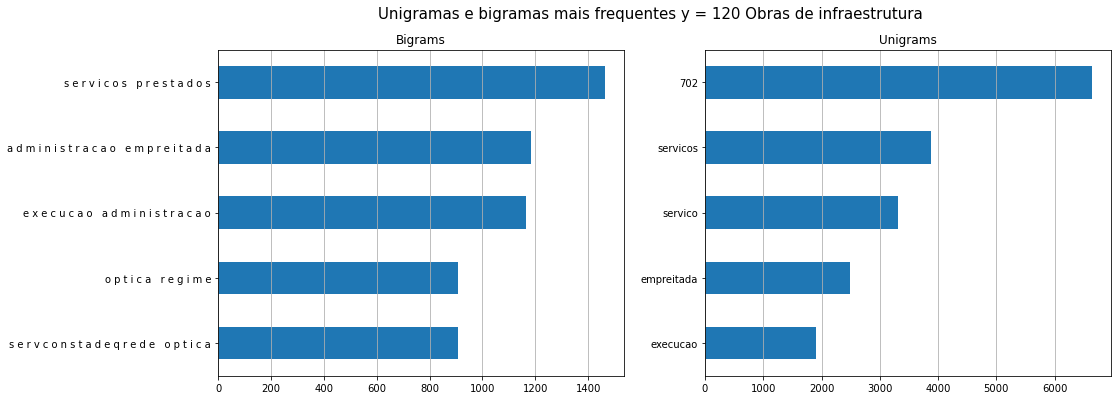

In [29]:
plot_uni_bigramas(120, 'Obras de infraestrutura')

Tamanho vocabulario unigramas: 658
Unigramas mais comuns: [('2001', 5882), ('2002', 2329), ('sv', 2066), ('servico', 2043), ('teca', 1898), ('importacoes', 1694), ('fiscal', 1524), ('armazenagem', 1461), ('lcl', 1417), ('portuario', 1287)]
Tamanho vocabulario bigramas: 935
Bigramas mais comuns [('servico teca', 1898), ('teca importacoes', 1694), ('sv portuario', 1282), ('portuario fiscal', 1282), ('servicos portuarios', 778), ('sv seg', 542), ('seg vigilan', 542), ('portuarios praticagem', 512), ('nao invasiva', 493), ('movimentacao mercadorias', 400)]


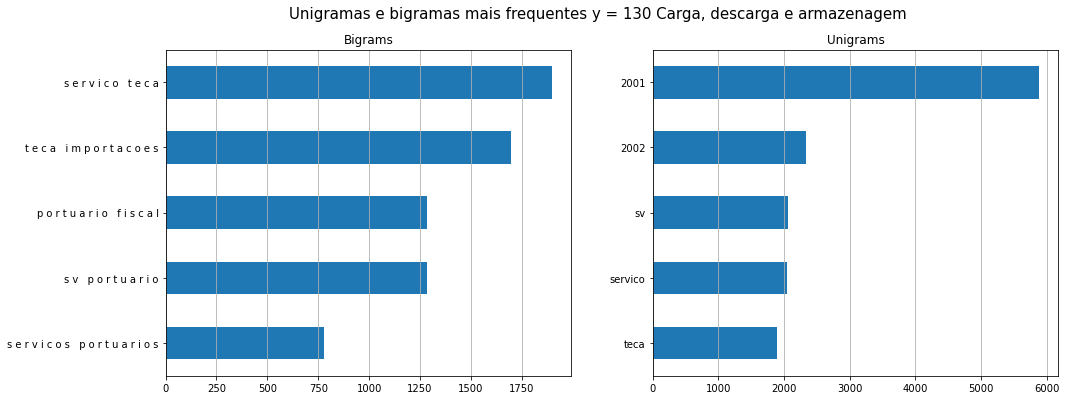

In [30]:
plot_uni_bigramas(130, 'Carga, descarga e armazenagem')

Tamanho vocabulario unigramas: 1207
Unigramas mais comuns: [('servicos', 5277), ('transporte', 4879), ('2001', 3837), ('1601', 2778), ('municipal', 2008), ('servico', 1888), ('natureza', 1559), ('1104', 915), ('armazenagem', 911), ('logistica', 848)]
Tamanho vocabulario bigramas: 1721
Bigramas mais comuns [('servicos transporte', 2149), ('transporte natureza', 1361), ('natureza municipal', 1359), ('servico transporte', 985), ('servicos logistica', 828), ('servicos prestados', 521), ('handling importacao', 516), ('prestacao servicos', 478), ('armazenagem container', 411), ('container ipa', 409)]


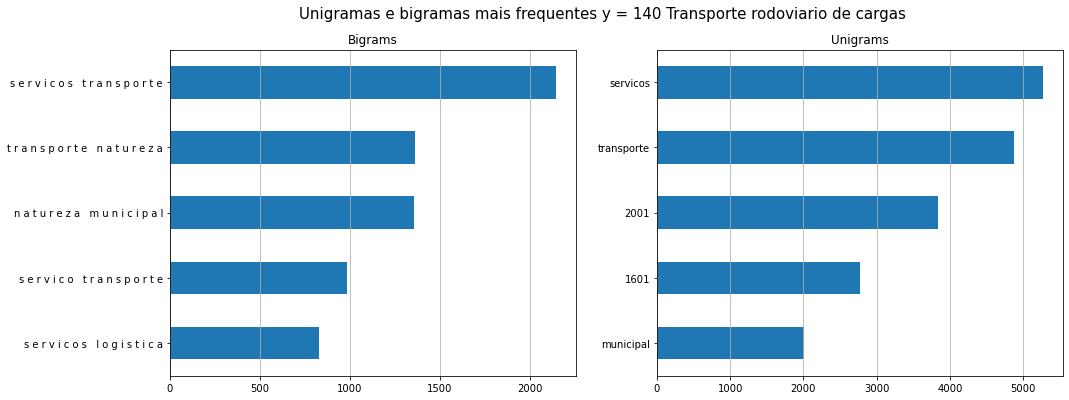

In [31]:
plot_uni_bigramas(140, 'Transporte rodoviario de cargas')

Tamanho vocabulario unigramas: 1217
Unigramas mais comuns: [('iob', 1937), ('escritorio', 1926), ('servico', 1709), ('sv', 1455), ('noticia', 1213), ('super', 1206), ('digital', 1202), ('assinaturas', 1056), ('1706', 1011), ('anuncio', 964)]
Tamanho vocabulario bigramas: 1503
Bigramas mais comuns [('super noticia', 1205), ('noticia sv', 1204), ('assinaturas digital', 1055), ('iob consultoria', 908), ('consultoria chat', 537), ('edicao integrada', 433), ('integrada impressao', 433), ('impressao jornais', 433), ('servico disponibilizacao', 354), ('disponibilizacao temporaria', 354)]


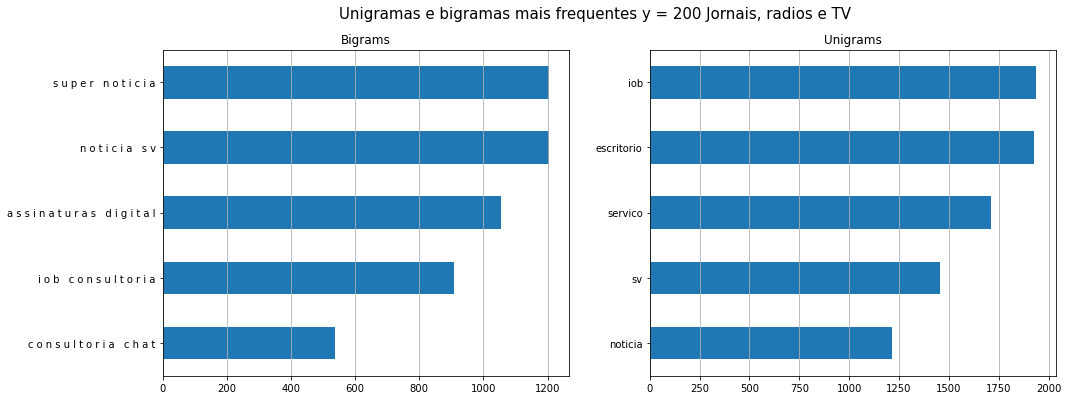

In [32]:
plot_uni_bigramas(200, 'Jornais, radios e TV')

In [33]:
# call center
drop_index =  treino.loc[(treino.text_clean.str.contains('call center')) & (treino.y != 30)].index
treino = treino.drop(index = drop_index)
drop_index = treino.loc[(treino.text_clean.str.contains('cobranca')) & (treino.y != 30)].index
treino = treino.drop(index = drop_index)

In [34]:
# construcao_civil: empreitada, subempreitada, construcao
drop_index = treino.loc[(treino.text_clean.str.contains('empreitada')) & (~ treino.y.isin([90,120]))].index
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('subempreitada')) & (~ treino.y.isin([90,120]))].index
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('construcao')) & (~ treino.y.isin([90,120]))].index
treino = treino.drop(index = drop_index)

In [35]:
# transporte e construcao_civil 999 (nao optantes)
# carga, descarga, armazenagem, portuario, praticagem, manutencao, obra, obras, engenharia, transporte, logistica
drop_index = treino.loc[(treino.text_clean.str.contains('carga')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('descarga')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('armazenagem')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('portuario')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('praticagem')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('manutencao')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('obra')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('obras')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('engenharia')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('transporte')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

drop_index = treino.loc[(treino.text_clean.str.contains('logistica')) & (treino.y == 999)].index 
treino = treino.drop(index = drop_index)

In [36]:
# excluindo da analise linhas com text_clean = ''
treino.loc[treino.text_clean == '', ['text_clean']] = 'servico'

# retirar linhas com y<>999 E text_clean: 'prestacao servico','servico','servicos','servicos prestados'
treino = drop_dfindex(treino, treino.loc[(treino.y != 999) & (treino.text_clean == 'prestacao servico')].index)
treino = drop_dfindex(treino, treino.loc[(treino.y != 999) & (treino.text_clean == 'servico')].index)
treino = drop_dfindex(treino, treino.loc[(treino.y != 999) & (treino.text_clean == 'servicos')].index)
treino = drop_dfindex(treino, treino.loc[(treino.y != 999) & (treino.text_clean == 'servicos prestados')].index)

# linhas (cada linha com 1 documento) para composicao de vetores com unigramas 
docs_train = treino.text_clean.values  # unigramas
ytrain = treino.y.values

In [37]:
def plot_distribuicao_classe(df, x, y):
    palette = sns.husl_palette(df[y].nunique())
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(x, fontsize=12)
    for nr,cat in enumerate(df[y].unique()):
        sns.kdeplot(data= df[df[y]==cat], x=x,  
                     cbar_kws={"alpha":0.8}, color=palette[nr], shade=True, ax=ax1)
        sns.histplot(data= df[df[y]==cat], x=x,  
                     bins=10, cbar_kws={"alpha":0.8}, color=palette[nr], ax=ax2)
    ax1.grid(True)
    ax2.grid(True)
    ax1.legend(df[y].unique())
    ax2.legend(df[y].unique())

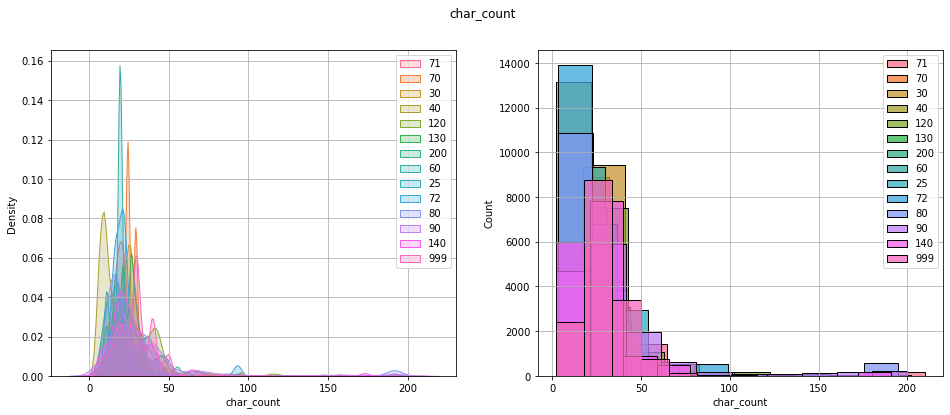

In [38]:
# distribuicao da soma de caracteres por documento
treino['char_count'] = treino["text_clean"].apply(lambda x: sum(len(word) for word in str(x).split(" "))) 
plot_distribuicao_classe(treino, 'char_count', 'y')

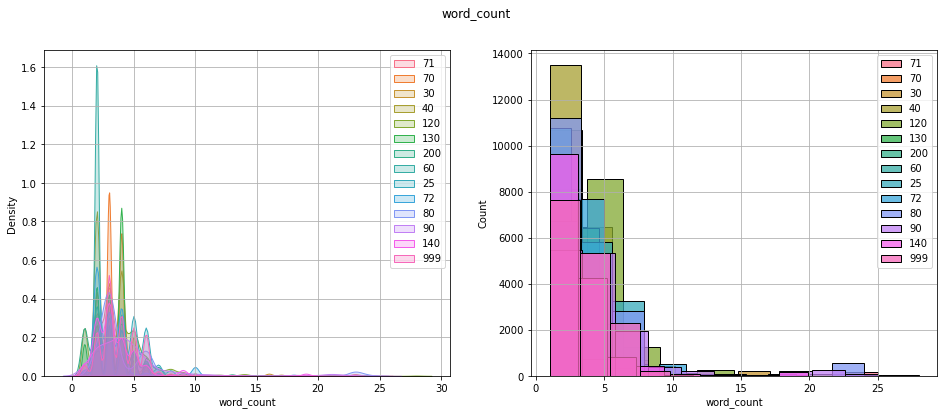

In [39]:
# distribuicao da contagem de palavras por documento
treino['word_count'] = treino["text_clean"].apply(lambda x: len(str(x).split(" ")))  # number_tokens
plot_distribuicao_classe(treino, 'word_count', 'y')

(14000, 4)


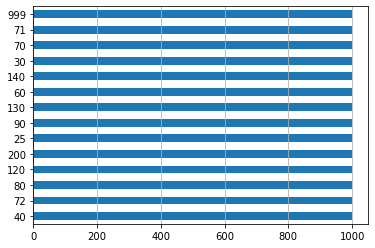

In [40]:
# DataSet de validação
path = r'../data/dataset_ML_val.parq'
val = pd.read_parquet(path, engine='auto')

# unigramas com limpeza do texto no DataSet de validação
val['text_clean'] = val[['cd_lc','text']].apply(doc_to_line, axis=1)
val.loc[val.text_clean == '', ['text_clean']] = 'servico'         # classe 999 quando limpeza_texto = ''

docs_val = val.text_clean.values 
yval = val.y.values

print(val.shape)
val.y.value_counts().sort_values().plot(kind='barh', legend=False).grid(axis='x');

Comparando resultados na vetorização dos documentos: 
- binary = palavras são marcadas como presentes (1) ou ausentes (0)
- count = contagem de ocorrências de cada palavra como um número inteiro
- freq = frequência de cada palavra no documento
- tfidf = frequência das palavras com penalização das palavras mais comuns (frequência + grau de raridade)
- hash = frequência das palavras com limitação das features (colunas) na matriz de vetores

In [41]:
# unigramas
binary_vectorizer = CountVectorizer(binary=True)
count_vectorizer = CountVectorizer()
freq_vectorizer = TfidfVectorizer(use_idf=False)
tfidf_vectorizer = TfidfVectorizer()
hashing_vectorizer = HashingVectorizer(n_features = 2 ** 11)

# bigramas
binary_vectorizer2 = CountVectorizer(binary=True, ngram_range=(1,2))
count_vectorizer2 = CountVectorizer(ngram_range=(1,2))
freq_vectorizer2 = TfidfVectorizer(use_idf=False, ngram_range=(1,2))
tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(1,2))
hashing_vectorizer2 = HashingVectorizer(n_features = 2 ** 11, ngram_range=(1,2))

In [42]:
# teste chi2 para seleção de features relevantes com unigramas
Xtrain_names_binary = teste_chi2(docs=docs_train, y=ytrain, vectorizer = binary_vectorizer)
binary_vectorizer_chi2 = CountVectorizer(binary=True, vocabulary = Xtrain_names_binary)

tamanho_vocabulario =  6315
(215298, 6315)
            feature  score    y
2869      graduacao 1.0000   80
2612           flat 0.9997   70
808        backbone 0.9873  130
5720          talao 0.9874   40
6047         unisys 1.0000   90
4565      portuario 1.0000  200
1580  contabilidade 0.9874  140
4913    reaventrega 1.0000  120
2220  encomnperiodo 0.9908   80
710          assist 1.0000   40

[10 rows x 3 columns]
vocab_testado: 6301


In [43]:
Xtrain_names_count = teste_chi2(docs=docs_train, y=ytrain, vectorizer = count_vectorizer)
count_vectorizer_chi2 = CountVectorizer(vocabulary = Xtrain_names_count)

tamanho_vocabulario =  6315
(215298, 6315)
            feature  score    y
5168            rio 0.9713  140
4203         outras 1.0000   71
1466       concreta 1.0000   90
1288  civileletrica 1.0000   90
5834       terminal 1.0000  140
1079         campos 0.9599  999
5609            stc 1.0000  120
653     armazenagem 1.0000  200
5781            tef 0.9820   72
4488     plataforma 1.0000   70

[10 rows x 3 columns]
vocab_testado: 6301


In [44]:
Xtrain_names_freq = teste_chi2(docs=docs_train, y=ytrain, vectorizer = freq_vectorizer)
freq_vectorizer_chi2 = TfidfVectorizer(use_idf=False, vocabulary = Xtrain_names_freq)

tamanho_vocabulario =  6315
(215298, 6315)
                feature  score    y
1128       carregamento 0.9996  200
3075                imp 0.9809  200
4354                ped 1.0000   90
5745          taxdoacao 0.9597   71
1069           cambagem 1.0000  999
4422          petrolina 1.0000  999
1129  carregamentosaida 1.0000   80
4225             pacote 1.0000  200
1978       distribuicao 0.9998   72
962          bookingcom 1.0000   40

[10 rows x 3 columns]
vocab_testado: 6175


In [45]:
Xtrain_names_tfidf = teste_chi2(docs=docs_train, y=ytrain, vectorizer = tfidf_vectorizer)
tfidf_vectorizer_chi2 = TfidfVectorizer(use_idf=True, vocabulary = Xtrain_names_tfidf)

tamanho_vocabulario =  6315
(215298, 6315)
             feature  score    y
5000     refrigerada 1.0000  130
428      agenciaepcm 1.0000  200
4439         picking 1.0000  130
4013              nh 0.9556   60
1724   cursogenerico 1.0000  200
1038       cabotagem 0.9925   71
3444             lgt 1.0000   30
326   acompanhamento 0.9981   60
5138          retido 1.0000  120
3658        maritimo 0.9885  120

[10 rows x 3 columns]
vocab_testado: 6247


In [46]:
# teste chi2 para seleção de features relevantes com unigramas e bigramas
Xtrain_names_binary2 = teste_chi2(docs=docs_train, y=ytrain, vectorizer = binary_vectorizer2)
binary_vectorizer2_chi2 = CountVectorizer(binary=True, vocabulary = Xtrain_names_binary2)

tamanho_vocabulario =  26580
(215298, 26580)
                     feature  score    y
21699           sapata freio 1.0000   90
22267  servico balanceamento 0.9997  999
11147                    fed 0.9878  130
22632               servicos 1.0000  140
14657   locsupgespam compras 0.9997   25
20407                redacao 0.9929   25
16959             obra ferro 1.0000   90
3493         aeronaves parte 0.9996  130
19804         psubst roldana 0.9997   80
18225             permanente 0.9694  130

[10 rows x 3 columns]
vocab_testado: 26553


In [47]:
Xtrain_names_count2 = teste_chi2(docs=docs_train, y=ytrain, vectorizer = count_vectorizer2)
count_vectorizer2_chi2 = CountVectorizer(vocabulary = Xtrain_names_count2)

tamanho_vocabulario =  26580
(215298, 26580)
                             feature  score    y
17070                      obras frs 1.0000   90
24332                   taxa servico 1.0000   25
14759                   lubrificacao 1.0000   71
15179            manutencao sistemas 0.9776  999
22052                   serv emendas 0.9767   71
3919                    analise area 0.9997  999
1145                      1401 manut 0.9756   71
16524                  nao perigosos 1.0000   70
16573              natureza servicos 0.9995   70
13185  infraestrutura administrativa 0.9851  140

[10 rows x 3 columns]
vocab_testado: 26553


In [48]:
Xtrain_names_freq2 = teste_chi2(docs=docs_train, y=ytrain, vectorizer = freq_vectorizer2)
freq_vectorizer2_chi2 = TfidfVectorizer(use_idf=False, vocabulary = Xtrain_names_freq2)

tamanho_vocabulario =  26580
(215298, 26580)
                      feature  score    y
17260                    oper 0.9893   25
1929              2002 ataero 0.9998   90
26181                 versoes 0.9953   25
2687             705 servicos 0.9505   71
6073                   cartao 0.9984   90
4944              autorizacao 1.0000  200
4790            ato cooperado 1.0000  999
25373  treinamento orientacao 1.0000  999
13526           intermediacao 1.0000  130
9418            ecomp aracruz 1.0000   70

[10 rows x 3 columns]
vocab_testado: 24243


In [49]:
Xtrain_names_tfidf2 = teste_chi2(docs=docs_train, y=ytrain, vectorizer = tfidf_vectorizer2)
tfidf_vectorizer2_chi2 = TfidfVectorizer(use_idf=True, vocabulary = Xtrain_names_tfidf2)

tamanho_vocabulario =  26580
(215298, 26580)
                feature  score    y
25906  vale transportes 0.9999   60
24399        tec gaspaj 0.9993   70
19313      prestados703 0.9999   90
12691             hotel 0.9959   72
566        106 programa 1.0000  999
25878              vaga 1.0000   60
7430         congeneres 0.9997  200
15623    mensagem natal 0.9980  200
14538       lmi6114 rec 0.9996   72
20452   redes districao 0.9896   90

[10 rows x 3 columns]
vocab_testado: 25240


In [50]:
results_ml = pd.DataFrame(columns = ['acc','precision_macro','recall_macro','f1_macro','mcc'])
def s_results(docs_train, ytrain, vectorizer=None, model=None, svd=None, docs_val=None, yval=None):
    if svd:
        pipe = Pipeline(steps=[('vectorizer', vectorizer),
                               ('svd', TruncatedSVD(n_components=100, n_iter=10, random_state=0)),
                               ('model', model)])
    else:
        pipe = Pipeline(steps=[('vectorizer', vectorizer),
                               ('model', model)])
    pipe.fit(docs_train, ytrain)
    yv_pred = pipe.predict(docs_val)
    acc = accuracy_score(yval, yv_pred)
    p_m = precision_score(yval, yv_pred, average='macro')
    r_m = recall_score(yval, yv_pred, average='macro')
    f1_m = f1_score(yval, yv_pred, average='macro')
    mcc = matthews_corrcoef(yval, yv_pred)
    return pd.Series(data=[acc, p_m, r_m, f1_m, mcc], index=['acc','precision_macro','recall_macro','f1_macro','mcc'])

## ML teste de algorítimos
#### legenda utilizada:
- NB: Naive Bayes MultinomialNB
- RF: Random Forest
- LG: Regressão Logística
- SVM: Suport Vector Machines
- uni: unigragmas
- bi: bigramas
- chi2: redução de features pelo método chi_quadrado
- SVD: redução de features pelo método SVD

## Naive Bayes MultinomialNB
- parâmetro padrão: alpha = 1.0

In [51]:
# binary
results_ml.loc['NB_binary_uni'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_binary_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_binary_bi'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_binary_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

In [52]:
# count
results_ml.loc['NB_count_uni'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_count_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_count_bi'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_count_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

In [53]:
# freq
results_ml.loc['NB_freq_uni'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_freq_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_freq_bi'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_freq_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

In [54]:
# tfidf
results_ml.loc['NB_tfidf_uni'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_tfidf_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_tfidf_bi'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

results_ml.loc['NB_tfidf_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2_chi2, 
                                     model= MultinomialNB(), docs_val=docs_val, yval=yval)

## Regressão Logística

In [55]:
# binary
results_ml.loc['LG_binary_uni'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_binary_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer, 
                                             svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_binary_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_binary_bi'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_binary_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2, 
                                            svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_binary_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

In [56]:
# count
results_ml.loc['LG_count_uni'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_count_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer, 
                                     svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_count_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_count_bi'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_count_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2, 
                                            svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_count_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

In [57]:
# freq
results_ml.loc['LG_freq_uni'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_freq_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer, 
                                           svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_freq_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_freq_bi'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_freq_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2, 
                                          svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_freq_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

In [58]:
# tfidf
results_ml.loc['LG_tfidf_uni'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_tfidf_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer, 
                                            svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_tfidf_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_tfidf_bi'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_tfidf_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2, 
                                           svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_tfidf_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2_chi2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

In [59]:
# hash
results_ml.loc['LG_hash_uni'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_hash_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer, 
                                           svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_hash_bi'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer2, 
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['LG_hash_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer2, 
                                          svd=True,
                                     model= LogisticRegression(solver='liblinear', random_state=0), docs_val=docs_val, yval=yval)

## SVM: Support Vector Machines
##### parâmetro padrão: kernel rbf, C = 1.0,  gamma = scale

In [60]:
# binary
results_ml.loc['SVM_binary_uni'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_binary_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer, 
                                     svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_binary_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_binary_bi'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_binary_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2, 
                                     svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_binary_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

In [61]:
# count
results_ml.loc['SVM_count_uni'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_count_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer, 
                                     svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_count_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_count_bi'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_count_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2, 
                                            svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_count_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

In [62]:
# freq
results_ml.loc['SVM_freq_uni'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_freq_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer, 
                                            svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_freq_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_freq_bi'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_freq_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2, 
                                           svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_freq_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

In [63]:
# tfidf
results_ml.loc['SVM_tfidf_uni'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_tfidf_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer, 
                                             svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_tfidf_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_tfidf_bi'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_tfidf_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2, 
                                            svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_tfidf_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2_chi2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

In [64]:
# hash
results_ml.loc['SVM_hash_uni'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_hash_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer, 
                                            svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_hash_bi'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer2, 
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['SVM_hash_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer2, 
                                           svd=True,
                                     model= SVC(random_state=0), docs_val=docs_val, yval=yval)

## Random Forest

In [65]:
# binary
results_ml.loc['RF_binary_uni'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_binary_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer, 
                                             svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_binary_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_binary_bi'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_binary_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2, 
                                            svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_binary_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= binary_vectorizer2_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

In [66]:
# count
results_ml.loc['RF_count_uni'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_count_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer, 
                                            svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_count_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_count_bi'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_count_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2, 
                                           svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_count_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= count_vectorizer2_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

In [67]:
# freq
results_ml.loc['RF_freq_uni'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_freq_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer, 
                                           svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_freq_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_freq_bi'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_freq_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2, 
                                          svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_freq_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= freq_vectorizer2_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

In [68]:
# tfidf
results_ml.loc['RF_tfidf_uni'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_tfidf_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer, 
                                            svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_tfidf_uni_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_tfidf_bi'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_tfidf_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2, 
                                           svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_tfidf_bi_chi2'] = s_results(docs_train, ytrain, vectorizer= tfidf_vectorizer2_chi2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

In [69]:
# hash
results_ml.loc['RF_hash_uni'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_hash_uni_SVD'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer, 
                                           svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_hash_bi'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer2, 
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

results_ml.loc['RF_hash_bi_SVD'] = s_results(docs_train, ytrain, vectorizer= hashing_vectorizer2, 
                                          svd=True,
                                     model= RandomForestClassifier(random_state=0), docs_val=docs_val, yval=yval)

## modelo ML com melhor resultado

In [70]:
results_ml.sort_values(by=['mcc'], ascending=False).head(20)

,acc,precision_macro,recall_macro,f1_macro,mcc
LG_binary_bi,0.8841,0.8903,0.8841,0.8850,0.8757
LG_count_bi,0.8837,0.8899,0.8837,0.8846,0.8752
SVM_tfidf_bi,0.8822,0.8907,0.8822,0.8835,0.8737
SVM_tfidf_uni_chi2,0.8816,0.8896,0.8816,0.8829,0.8731
SVM_freq_bi,0.8816,0.8900,0.8816,0.8828,0.8731
SVM_tfidf_bi_chi2,0.8816,0.8895,0.8816,0.8828,0.8730
SVM_tfidf_uni,0.8814,0.8894,0.8814,0.8826,0.8729
SVM_freq_uni,0.8811,0.8897,0.8811,0.8825,0.8726
SVM_freq_uni_chi2,0.8811,0.8896,0.8811,0.8825,0.8726
SVM_freq_bi_chi2,0.8811,0.8896,0.8811,0.8825,0.8726


## Model Tuning

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
vectorizer= binary_vectorizer2
docs_vect = vectorizer.fit_transform(docs_train)

In [73]:
grid = {'solver': ['liblinear','lbfgs','sag','saga'], 
        'C': [10., 1.]}
grid_search = GridSearchCV(LogisticRegression(),
                          grid,
                          n_jobs=-1)
grid_search.fit(docs_vect, ytrain)

/home/00084776714/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10.0, 1.0],
                         'solver': ['liblinear', 'lbfgs', 'sag', 'saga']})

In [74]:
grid_search.best_params_

{'C': 10.0, 'solver': 'sag'}

In [75]:
model= LogisticRegression(**grid_search.best_params_)
pipe = Pipeline(steps=[('vectorizer', vectorizer),
                               ('model', model)])
pipe.fit(docs_train, ytrain)

/home/00084776714/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('model', LogisticRegression(C=10.0, solver='sag'))])

In [76]:
yv_pred = pipe.predict(docs_val)
matthews_corrcoef(yval, yv_pred)

0.8784409142350387

## Salvando o melhor modelo de ML

In [77]:
# save ML best model
with open(r"../best_models/ML_model.pickle", 'wb') as handle:
    pickle.dump(pipe, handle)

## Carregando o melhor modelo de ML

In [78]:
def load_doc(filename):
    ''' # load doc into memory '''
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [79]:
with open(r"../best_models/ML_model.pickle", 'rb') as handle:
    loaded_pipe = pickle.load(handle)
# vocabulario
loaded_vocab = load_doc(r'../best_models/vocab.txt')

In [80]:
yv_pred = loaded_pipe.predict(docs_val)
matthews_corrcoef(yval, yv_pred)

0.8784409142350387

In [81]:
print(classification_report(yval, yv_pred, digits=4))

              precision    recall  f1-score   support

          25     0.8300    0.9030    0.8649      1000
          30     0.9850    0.9880    0.9865      1000
          40     0.9834    0.9490    0.9659      1000
          60     0.9692    0.9750    0.9721      1000
          70     0.9739    0.8970    0.9339      1000
          71     0.9836    0.9600    0.9717      1000
          72     0.9385    0.9920    0.9645      1000
          80     0.9930    0.9870    0.9900      1000
          90     0.7807    0.7440    0.7619      1000
         120     0.8961    0.8190    0.8558      1000
         130     0.8312    0.7240    0.7739      1000
         140     0.7120    0.6800    0.6957      1000
         200     0.9690    0.9060    0.9364      1000
         999     0.6535    0.8900    0.7536      1000

    accuracy                         0.8867     14000
   macro avg     0.8928    0.8867    0.8876     14000
weighted avg     0.8928    0.8867    0.8876     14000



In [82]:
# matriz de confuso: columns: True,  index:   Predict
cm = confusion_matrix(yval, yv_pred)
pd.DataFrame(data=cm, columns=np.sort(val.y.unique()), index=np.sort(val.y.unique()))

,25,30,40,60,70,71,72,80,90,120,130,140,200,999
25,903,6,2,6,0,0,0,0,17,2,0,5,6,53
30,0,988,1,0,0,0,0,0,2,0,0,0,1,8
40,6,0,949,0,0,1,0,0,5,1,0,4,1,33
60,0,0,1,975,0,0,1,0,3,0,0,17,1,2
70,0,0,0,3,897,1,2,0,5,7,21,33,1,30
71,1,0,0,0,0,960,0,0,26,3,0,0,1,9
72,1,0,0,0,0,0,992,0,0,1,4,0,0,2
80,0,0,0,0,2,0,1,987,0,1,0,4,0,5
90,10,0,2,0,1,0,0,6,744,62,0,3,1,171
120,4,1,1,0,0,3,0,0,99,819,1,5,12,55


## Fazendo predições ML:

In [83]:
def predict_ml_classe(lc, text, l_vocab, pipe):
    l_text_clean = clean_doc(text, False)
    l_text_clean = [w for w in l_text_clean if w in l_vocab]
    l_lc = list()
    lc_clean = re.sub(r'[^\w\s]', '', str(lc))
    if lc_clean in l_vocab:
        l_lc.append(lc_clean)  
        l_lc.extend(l_text_clean)    
        l_lc = [w for w in l_lc if w != '']
        return pipe.predict(l_lc)[0]
    return pipe.predict(l_text_clean)[0]

In [84]:
# Descrição de serviço de TI - classe 25
cd = ''
texto = 'desenvolvimento de sistemas'
classe = predict_ml_classe(cd,texto, loaded_vocab, loaded_pipe)
print(f'{texto}: classe {classe}')

desenvolvimento de sistemas: classe 25


In [86]:
# Descrição de serviço de hotelaria - classe 40
cd = ''
texto = 'hospedagem'
classe = predict_ml_classe(cd,texto, loaded_vocab, loaded_pipe)
print(f'{texto}: classe {classe}')

hospedagem: classe 40


In [87]:
# Descrição de serviço de obra de construo civil grupo CNAE 412, 432, 433,439 - classe 90
cd = ''
texto = 'obra de construção civil'
classe = predict_ml_classe(cd,texto, loaded_vocab, loaded_pipe)
print(f'{texto}: classe {classe}')

obra de construção civil: classe 90


In [88]:
# Descrição de serviço de carga, descarga e armazenagem - classe 130
cd = ''
texto = 'armazenagem'
classe = predict_ml_classe(cd,texto, loaded_vocab, loaded_pipe)
print(f'{texto}: classe {classe}')

armazenagem: classe 130


In [89]:
# Descrição de serviço prestado por empresas jornalsticas e de radiodifuso sonora - classe 200
cd = ''
texto = 'proganda em jornal'
classe = predict_ml_classe(cd,texto, loaded_vocab, loaded_pipe)
print(f'{texto}: classe {classe}')

proganda em jornal: classe 200


In [90]:
import sklearn
print(sklearn.__version__)

0.23.2
